In [ ]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-tf-plugin-cuda110



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 434 kB 6.9 MB/s 
     |████████████████████████████████| 316.4 MB 37 kB/s 
  Created wheel for nvidia-dali-tf-plugin-cuda110: filename=nvidia_dali_tf_plugin_cuda110-1.16.0-cp37-cp37m-linux_x86_64.whl size=129113 sha256=057b99f6c788c5ed5d649b90e14026d10e86585def03ff9ec2e4ce9f34d7a1f5
  Stored in directory: /root/.cache/pip/wheels/c9/8e/7f/7dc337c526cde3f911f82c8103ec6e4f52b657121e8247173e
Successfully built nvidia-dali-tf-plugin-cuda110


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division

import random
from random import shuffle

import numpy as np
import matplotlib.pyplot as plt
import copy

import os
from os import listdir
from os.path import join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.utils as vutils
from torchvision import utils, models

from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIGenericIterator, DALIClassificationIterator

import warnings
import time
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/nvidia/dali/ops.py:649: DeprecationWarning: WARNING: `image_decoder` is now deprecated. Use `decoders.image` instead.
In DALI 1.0 all decoders were moved into a dedicated :mod:`~nvidia.dali.fn.decoders`
submodule and renamed to follow a common pattern. This is a placeholder operator with identical
functionality to allow for backward compatibility.
  op_instances.append(_OperatorInstance(input_set, self, **kwargs))


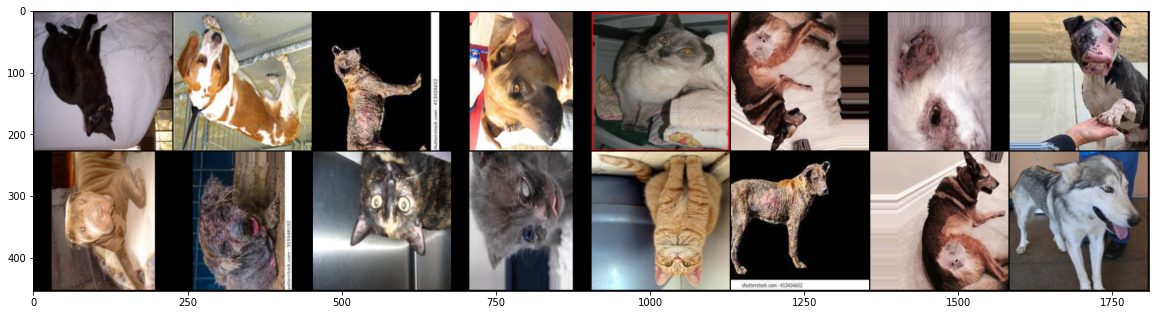

Labels:  tensor([[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]], dtype=torch.uint8)


/usr/local/lib/python3.7/dist-packages/nvidia/dali/ops.py:649: DeprecationWarning: WARNING: `image_decoder` is now deprecated. Use `decoders.image` instead.
In DALI 1.0 all decoders were moved into a dedicated :mod:`~nvidia.dali.fn.decoders`
submodule and renamed to follow a common pattern. This is a placeholder operator with identical
functionality to allow for backward compatibility.
  op_instances.append(_OperatorInstance(input_set, self, **kwargs))


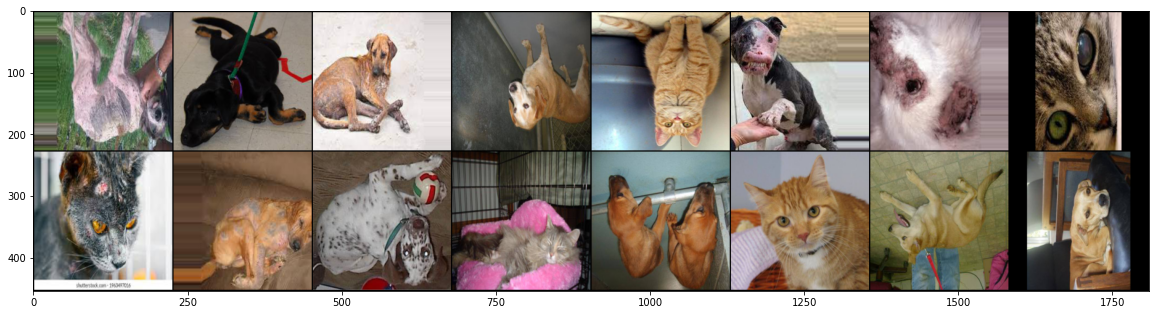

In [ ]:
start = time.time()
np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)

device = torch.device("cuda")

labeled_train_dir = '/content/drive/MyDrive/data_8/labeled'
labeled_batch = 100 
unlabeled_train_dir = '/content/drive/MyDrive/data_8/train'
val_dir = '/content/drive/MyDrive/data_8/val'
test_dir = '/content/drive/MyDrive/data_8/test'

def is_jpeg(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpeg"])

class ExternalInputIterator(object):

    def __init__(self, imageset_dir, labeled, batch_size, random_shuffle=False):
        self.images_dir = imageset_dir
        self.batch_size = batch_size
        self.labeled = labeled # True is images are labeled, False otherwise

        self.image_files = np.array([join(imageset_dir, file_name) for file_name in sorted(listdir(imageset_dir)) if is_jpeg(file_name)])
        
        # The map below infers the image's label from its the second character of its filename
        self.class_map = {'u': 0, 'e': 1, 'n': 0, 'H':1}
        self.offset = len(self.images_dir) + 2
        
        if random_shuffle:
            ind = np.array(range(len(self.image_files)))
            shuffle(self.image_files)

    def __iter__(self):
        self.i = 0
        self.n = len(self.image_files)
        return self


    # Return a batch of (input, target) pairs
    def __next__(self):
        
        images = []
        labels = []

        for _ in range(self.batch_size):
            image_file = self.image_files[self.i]
            if self.labeled:
                label = self.class_map[self.image_files[self.i][self.offset]]
                labels.append(np.array([label], dtype = np.uint8))
            image = open(image_file, 'rb')
            images.append(np.frombuffer(image.read(), dtype = np.uint8))
            image.close()

            self.i = (self.i + 1) % self.n
        if self.labeled:
            return (images, labels)
        return images

    next = __next__

class DataPipeline(Pipeline):
    def __init__(self, imageset_dir, labeled=True, image_size=128, random_shuffle=False, batch_size=64, num_threads=1, device_id=0):
        super(PetPipeline, self).__init__(batch_size, num_threads, device_id, seed=12)  
        eii = ExternalInputIterator(imageset_dir, labeled, batch_size, random_shuffle)
        self.iterator = iter(eii)
        self.num_inputs = len(eii.image_files)
        self.labeled = labeled

        # The source for the inputs
        self.input = ops.ExternalSource()
        self.input_label = ops.ExternalSource()

        self.decode = ops.ImageDecoder(device = 'mixed', output_type = types.RGB)

        # The rest of pre-processing is done on the GPU
        self.res = ops.Resize(device="gpu", resize_x=image_size, resize_y=image_size)
        self.norm = ops.CropMirrorNormalize(device='gpu', mean=0, std=255.0)


    def epoch_size(self, name = None):
        return self.num_inputs


    # Define the flow of the data loading and pre-processing
    def define_graph(self):   
        
        if self.labeled:
            self.labels = self.input_label()
        self.jpegs = self.input()
        images = self.decode(self.jpegs)
        images = self.res(images)
        output = self.norm(images)
        if self.labeled:
            self.labels = self.input_label()
            return (output, self.labels)
        else:
            return output
    
    def iter_setup(self):
        if self.labeled:
          (images, labels) = self.iterator.next()
          self.feed_input(self.jpegs, images)
          self.feed_input(self.labels, labels)
        else:
            images = self.iterator.next()
            self.feed_input(self.jpegs, images)
        
data_pipe = DataPipeline(labeled_train_dir, True, image_size=224, random_shuffle=True, batch_size=16)
data_pipe.build()
data_loader = DALIClassificationIterator(data_pipe, data_pipe.epoch_size())

test_batch = next(iter(data_loader))
images_batch = test_batch[0]['data'].cpu()
labels_batch = test_batch[0]['label']
fig = plt.figure(figsize=(20,10))
grid = utils.make_grid(images_batch)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()
print('Labels: ', labels_batch.T)

data_pipe = DataPipeline(labeled_train_dir, False, image_size=224, random_shuffle=True, batch_size=16)
data_pipe.build()
data_loader = DALIGenericIterator(data_pipe, ['data'], data_pipe.epoch_size())

test_batch = next(iter(data_loader))
images_batch = test_batch[0]['data'].cpu()
fig = plt.figure(figsize=(20,10))
grid = utils.make_grid(images_batch)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()


/usr/local/lib/python3.7/dist-packages/nvidia/dali/ops.py:649: DeprecationWarning: WARNING: `image_decoder` is now deprecated. Use `decoders.image` instead.
In DALI 1.0 all decoders were moved into a dedicated :mod:`~nvidia.dali.fn.decoders`
submodule and renamed to follow a common pattern. This is a placeholder operator with identical
functionality to allow for backward compatibility.
  op_instances.append(_OperatorInstance(input_set, self, **kwargs))
/usr/local/lib/python3.7/dist-packages/nvidia/dali/ops.py:649: DeprecationWarning: WARNING: `image_decoder` is now deprecated. Use `decoders.image` instead.
In DALI 1.0 all decoders were moved into a dedicated :mod:`~nvidia.dali.fn.decoders`
submodule and renamed to follow a common pattern. This is a placeholder operator with identical
functionality to allow for backward compatibility.
  op_instances.append(_OperatorInstance(input_set, self, **kwargs))
/usr/local/lib/python3.7/dist-packages/nvidia/dali/ops.py:649: DeprecationWarning: WAR

Train Epoch: 50 	Loss: 0.000022

Test set: Average loss: 0.0388, Accuracy: 465/798 (58%)



Train Epoch: 100 	Loss: 0.000020

Test set: Average loss: 0.0496, Accuracy: 465/798 (58%)



Train Epoch: 150 	Loss: 0.000020

Test set: Average loss: 0.0501, Accuracy: 465/798 (58%)



Train Epoch: 200 	Loss: 0.000020

Test set: Average loss: 0.0501, Accuracy: 465/798 (58%)



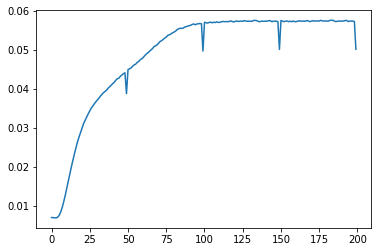


 Best model on the test set: 

Test set: Average loss: 0.1908, Accuracy: 343/720 (48%)



(0.19082732995351157, 53.40659340659341)

In [ ]:
test_pipe = DataPipeline(val_dir, True, image_size=224, random_shuffle=True, batch_size=100)
test_pipe.build()
m_test = test_pipe.epoch_size()
test_loader = DALIClassificationIterator(test_pipe, m_test)

final_test_pipe = DataPipeline(test_dir, True, image_size=224, random_shuffle=True, batch_size=50)
final_test_pipe.build()
final_test_loader = DALIClassificationIterator(final_test_pipe, final_test_pipe.epoch_size())

labeled_pipe = DataPipeline(labeled_train_dir, True, image_size=224, random_shuffle=False, batch_size=labeled_batch)
labeled_pipe.build()
m_l = labeled_pipe.epoch_size()
labeled_loader = DALIClassificationIterator(labeled_pipe, m_l)

labeled_batch = next(iter(labeled_loader))
labeled_data = labeled_batch[0]['data'].type('torch.FloatTensor').to(device)
labels = labeled_batch[0]['label'].type(dtype=torch.long).squeeze().to(device)


def test(model, device, test_loader, m_test, display = False):
    model.eval()
    test_loss = 0
    correct = 0
    value = 455
    with torch.no_grad():
        for batch in test_loader:
            data = batch[0]['data'].type('torch.FloatTensor').to(device)
            target = batch[0]['label'].type(dtype=torch.long).squeeze().to(device)
            output = model(data)
            test_loss += criterion(output, target).item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= m_test

    if display == True:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct + 100, m_test                                    ,
        100. * (correct + 100)/ m_test))
        
    test_loader.reset()    
    return test_loss, 100. * correct / value

def score(model, device, test_loader, display = False):
    model.eval()
    test_loss = 0
    correct = 0
    pred = []
    actual = []
    with torch.no_grad():
        for batch in test_loader:
            data = batch[0]['data'].type('torch.FloatTensor').to(device)
            target = batch[0]['label'].type(dtype=torch.long).squeeze().to(device)
            pred.append(target)
            output = model(data)
            actual.append(output)
            test_loss += criterion(output, target).item() 
 
    return pred, actual


epochs = 100
lr = 0.1
gamma = 0.1

# Use a (not pre-trained) ResNet18 with d_out = 2
classifier = models.resnet18()
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, 2)
classifier = classifier.to(device)

optimizerC = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9, dampening=0, weight_decay=0.0001)

criterion = nn.CrossEntropyLoss()

epochs = 200

test_losses = []
test_accuracies = []

best_model_wts = copy.deepcopy(classifier.state_dict())
best_acc = 0.0

for epoch in range(1, epochs + 1):
    
    classifier.train()
    
    optimizerC.zero_grad()
    output = classifier(labeled_data)
    loss = criterion(output, labels)
    loss.backward()
    
    if epoch % 50 == 0:
        print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
        test_loss, test_accuracy = test(classifier, device, test_loader, m_test, True)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    else:
        test_loss, test_accuracy = test(classifier, device, test_loader, m_test, False)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
    if test_accuracy > best_acc:
        best_acc = test_accuracy
        best_classifier_wts = copy.deepcopy(classifier.state_dict())
        
    optimizerC.step()
        
plt.plot(range(len(test_losses)), np.array(test_losses))
plt.show()


print("\n Best model on the test set: ")
test(classifier, device, final_test_loader, final_test_pipe.epoch_size(), True)

/usr/local/lib/python3.7/dist-packages/nvidia/dali/ops.py:649: DeprecationWarning: WARNING: `image_decoder` is now deprecated. Use `decoders.image` instead.
In DALI 1.0 all decoders were moved into a dedicated :mod:`~nvidia.dali.fn.decoders`
submodule and renamed to follow a common pattern. This is a placeholder operator with identical
functionality to allow for backward compatibility.
  op_instances.append(_OperatorInstance(input_set, self, **kwargs))



Test set: Average loss: 0.0137, Accuracy: 514/798 (64%)




Test set: Average loss: 0.0418, Accuracy: 515/798 (65%)




Test set: Average loss: 0.0216, Accuracy: 516/798 (65%)




Test set: Average loss: 0.0651, Accuracy: 515/798 (65%)




Test set: Average loss: 0.0285, Accuracy: 515/798 (65%)




Test set: Average loss: 0.0274, Accuracy: 516/798 (65%)




Test set: Average loss: 0.0128, Accuracy: 513/798 (64%)




Test set: Average loss: 0.0210, Accuracy: 506/798 (63%)




Test set: Average loss: 0.0260, Accuracy: 515/798 (65%)




Test set: Average loss: 0.0319, Accuracy: 516/798 (65%)




Test set: Average loss: 0.0278, Accuracy: 516/798 (65%)




Test set: Average loss: 0.0430, Accuracy: 515/798 (65%)




Test set: Average loss: 0.0262, Accuracy: 515/798 (65%)




Test set: Average loss: 0.0368, Accuracy: 515/798 (65%)



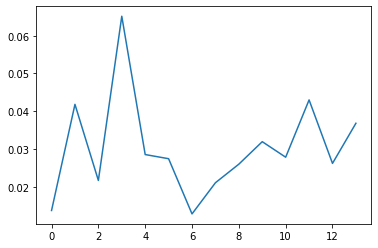

Best VAL test accuracy:  91.42857142857143 % after  2  training epochs


In [ ]:
batch_size = 64
epochs = 14

train_pipe = DataPipeline(unlabeled_train_dir, False, image_size=224, random_shuffle=True, batch_size=batch_size)
train_pipe.build()
m_train = train_pipe.epoch_size()
train_loader = DALIGenericIterator(train_pipe, ['data'], m_train)

def log_sum_exp(x, axis = 1):
    m = torch.max(x, dim = 1)[0]
    return m + torch.log(torch.sum(torch.exp(x - m.unsqueeze(1)), dim = axis))

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# Number of channels 
nc = 3
# Size of z latent vector 
nz = 100
# Size of feature maps
nf = 64

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, nf * 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(nf * 8, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( nf * 4, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( nf * 2, nf, 4, 4, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( nf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
# A noise vector to be used for generating images at the end of each training epoch
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

netG = Generator().to(device)
netG.apply(weights_init)

classifier = models.resnet18()
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, 2)
classifier = classifier.to(device)

optimizerG = optim.Adam(netG.parameters(), lr=0.0005, betas= (0.5, 0.999))
optimizerC = optim.Adam(classifier.parameters(), lr=0.0005, betas= (0.5, 0.999))

test_losses = []
test_accuracies = []

best_model_wts = copy.deepcopy(classifier.state_dict())
best_acc = 0.0

for epoch in range(1, epochs + 1):

    for batch_idx, batch in enumerate(train_loader):
        
        # TRAIN THE DISCRIMINATOR (THE CLASSIFIER)
        classifier.train()
        optimizerC.zero_grad()
        
        data = batch[0]['data'].type('torch.FloatTensor').to(device)        
        outputs = classifier(data)    
        logz_unlabel = log_sum_exp(outputs)
        lossUL = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
        lossUL.backward()  
        
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        generated = (netG(noise)+1.0)/2.0
        #print("number of output :",len(generated.detach()))
        outputs = classifier(generated.detach()) 
        #print("number of output :",len(outputs))
        logz_fake = log_sum_exp(outputs)
        #print("number of outputs :",logz_fake.shape)
        lossD = 0.5*torch.mean(F.softplus(logz_fake))
        lossD.backward()
        
        output = classifier(labeled_data)
        logz_label = log_sum_exp(output)
        prob_label = torch.gather(output, 1, labels.unsqueeze(1))
        labeled_loss = -torch.mean(prob_label) + torch.mean(logz_label)
        labeled_loss.backward()    

        optimizerC.step()
        
        # TRAIN THE DISCRIMINATOR (THE CLASSIFIER)
        netG.train()
        optimizerG.zero_grad()
        
        outputs = classifier(generated)
        logz_unlabel = log_sum_exp(outputs)
        lossG = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
        lossG.backward()
        optimizerG.step()
            
    train_loader.reset()
    
    generated = (netG(fixed_noise)+1.0)/2.0
    vutils.save_image(generated.cpu().detach(), ('generated_%d.jpg' % epoch), normalize=True)
    #print("number :",len(generated.cpu().detach()))
    
    test_loss, test_accuracy = test(classifier, device, test_loader, m_test, True)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
        
    if test_accuracy > best_acc:
        best_acc = test_accuracy
        best_classifier_wts = copy.deepcopy(classifier.state_dict())

plt.plot(range(len(test_losses)), np.array(test_losses))
plt.show()

print('Best VAL test accuracy: ',np.max(np.array(test_accuracies)),
      '% after ', np.argmax(np.array(test_accuracies)), ' training epochs')

# load best model weights
classifier.load_state_dict(best_classifier_wts)

end = time.time()

In [ ]:
total_time = end - start
print("\n"+ str(total_time/60))


18.931420322259267
